#Imports

In [0]:
pip install adversarial-robustness-toolbox

     |████████████████████████████████| 491kB 2.8MB/s 
     |████████████████████████████████| 7.1MB 12.3MB/s 
  Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1


In [0]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
from tensorflow import keras
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import art

#Global Variables

In [0]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']


#Util Functions

In [0]:

def show_image(image, label=None):

  class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

  plt.figure(figsize=(15,15))
  plt.subplot(5,5,1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(image, cmap=plt.cm.binary)
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
  if label != None:
   plt.xlabel(class_names[label[0]])
  plt.show()


def get_label(model_prediction):
  """given the prediction of a model this function 
  prints out the associated label"""

  return class_names[np.argmax(model_prediction)]


def get_attack_name(attack):
  return str(attack).split('.')[3]

def get_attack_type(attack):
  return str(attack).split('.')[2]
  
def get_defense_name(defense):
  return str(defense).split('.')[3]

def get_defense_type(defense):
  return str(defense).split('.')[2]

#Data

In [0]:
#loading data
(x_train,y_train),(x_test,y_test) = keras.datasets.cifar10.load_data()

170500096/170498071 [==============================] - 12s 0us/step


In [0]:
#normalizing data
x_train = x_train/255
x_test = x_test/255 


In [0]:
#getting even number of classes and storing them in x_subsample and y_subsample
x_subsample = np.reshape(np.array([]),(0,32,32,3))
y_subsample = np.reshape(np.array([],dtype='int'),(0,1))

for i in range(len(np.unique(y_test))):
  
  index = (y_test==i).reshape(10000)
  x_subsample = np.append(x_subsample,x_test[index][:10],axis=0)
  y_subsample = np.append(y_subsample, y_test[index][:10],axis=0)
  

In [0]:
#showing that there are 10 examples from each class
from collections import Counter

Counter(np.reshape(y_subsample,(100)))

Counter({0: 10, 1: 10, 2: 10, 3: 10, 4: 10, 5: 10, 6: 10, 7: 10, 8: 10, 9: 10})

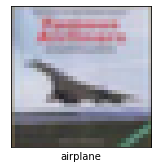

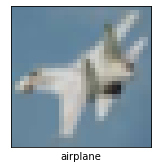

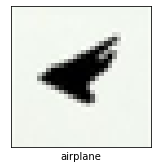

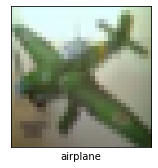

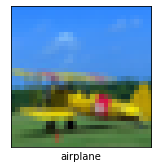

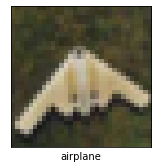

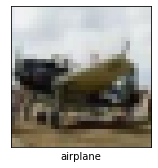

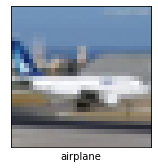

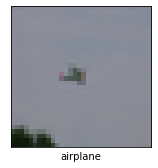

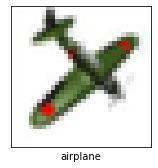

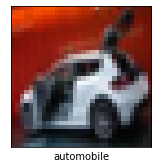

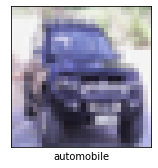

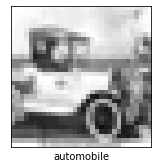

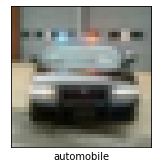

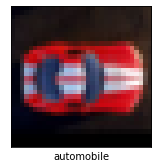

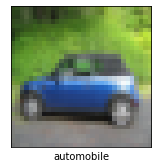

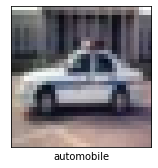

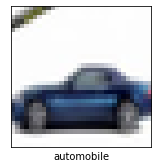

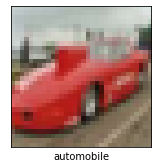

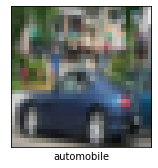

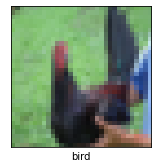

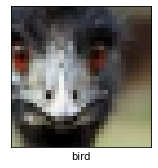

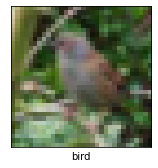

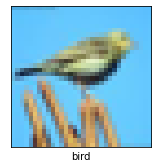

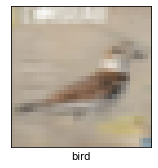

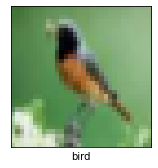

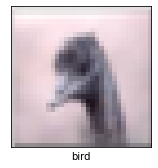

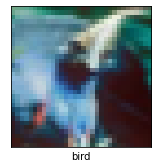

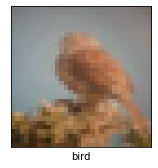

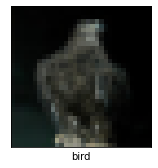

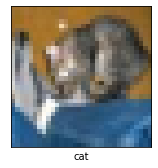

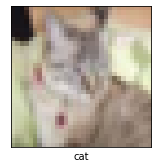

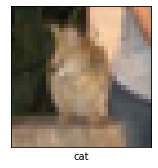

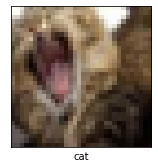

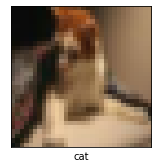

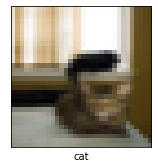

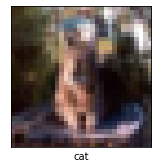

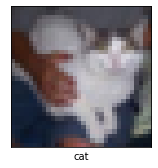

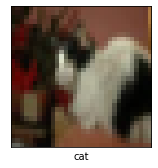

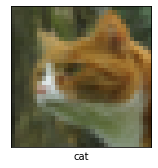

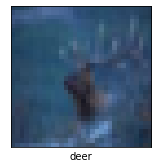

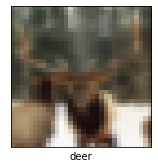

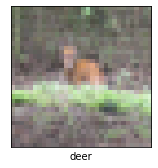

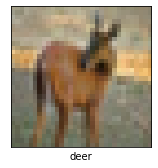

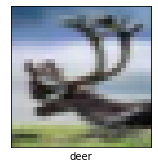

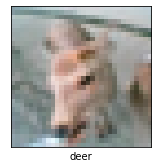

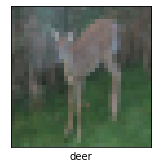

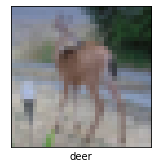

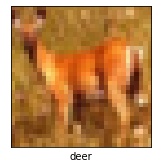

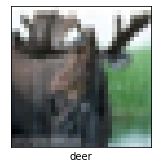

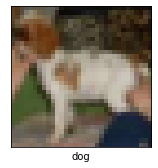

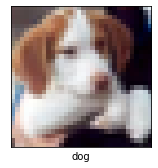

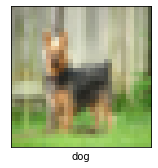

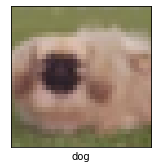

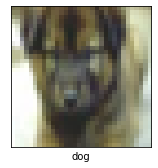

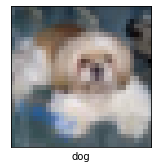

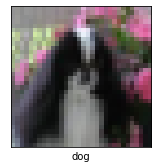

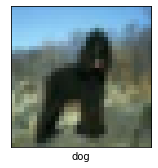

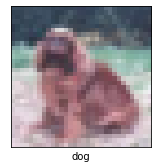

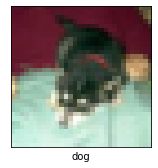

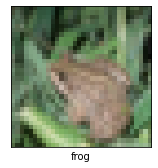

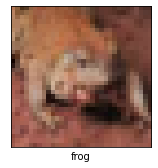

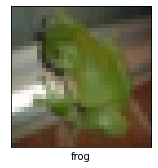

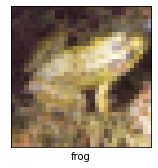

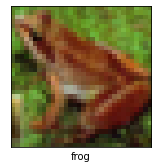

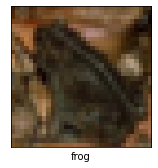

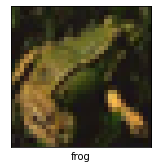

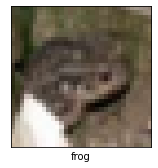

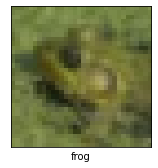

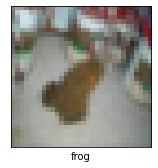

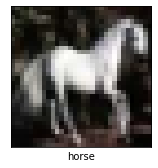

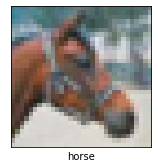

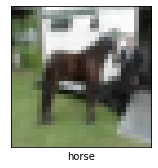

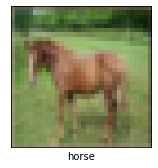

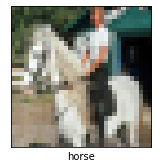

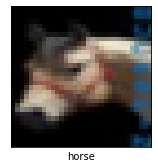

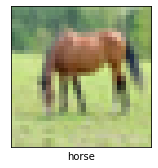

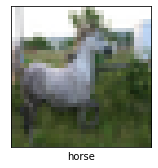

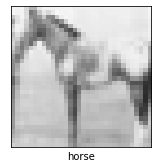

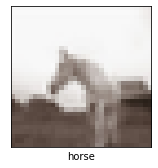

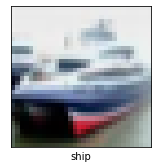

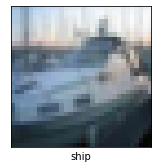

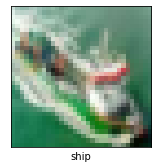

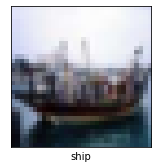

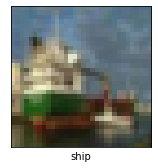

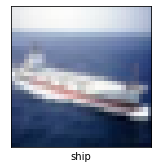

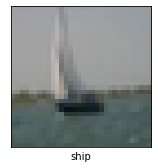

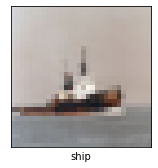

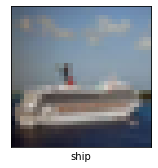

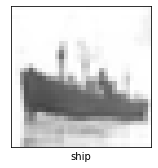

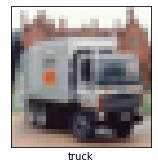

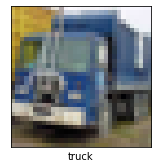

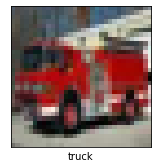

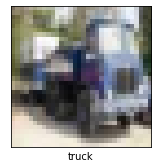

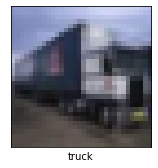

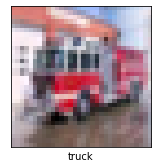

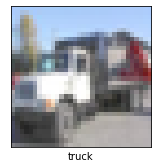

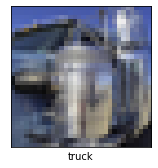

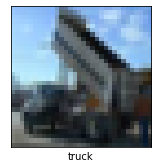

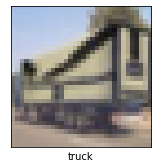

In [0]:
#checking that the training examples match the labels chosen
for i in range(len(y_subsample)):
  show_image(x_subsample[i],y_subsample[i])

##visualizing data

In [0]:
print('feature_shape',x_subsample[0].shape)
print('label_shape',y_train[0].shape)

feature_shape (32, 32, 3)
label_shape (1,)


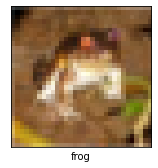

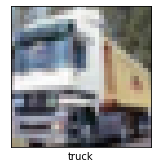

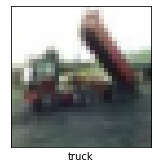

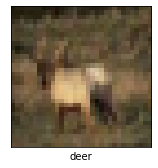

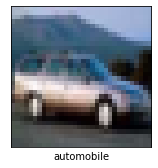

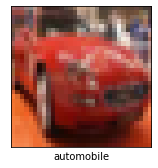

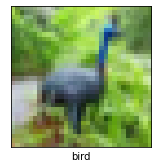

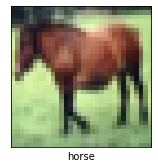

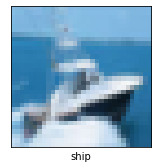

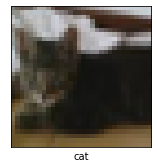

In [0]:
#showing first 10 images 
for i in range(10):

  show_image(x_train[i],y_train[i])


#Models

####victim model

In [0]:
#loading victim model
victim_model = keras.Sequential([keras.layers.Input(shape=(32,32,3)),
                                 hub.KerasLayer("https://tfhub.dev/deepmind/ganeval-cifar10-convnet/1",
                                                input_shape=(32,32,3),
                                                output_shape=(10))
                                 ])


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [0]:
#building victim model to expect input shape of (batch size, image_height, image_width, image_depth/num_channels)
victim_model.build(input_shape=(100,32,32,3))

In [0]:
metrics = ['mae','accuracy',]#whatever else we decide on 

In [0]:
victim_model.compile(keras.optimizers.SGD(momentum=0.9,learning_rate=0.1),
                     loss=keras.losses.binary_crossentropy,
                     metrics = metrics)

In [0]:
#model summary
victim_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 10)                7796426   
Total params: 7,796,426
Trainable params: 0
Non-trainable params: 7,796,426
_________________________________________________________________


####Classifier

In [0]:

classifier = art.classifiers.KerasClassifier(model = victim_model)

#Attacks and Defenses

####Attack Function

In [0]:
def perform_attack(attack, defenses = [], x=x_subsample, y=y_subsample):
  """Performs attack and show results.
  If defenses are not none it performs each defense and
  shows results."""

  #attack classifier
  classifier = attack.classifier

  #adversarial examples
  if get_attack_name(attack)=='adversarial_patch':

    attack.generate(x)
    x_adversarial = adversarial_patch.apply_patch(x.copy(),0.3)

  else:
    x_adversarial = attack.generate(x,y)

  #metrics to measure 
  from sklearn.metrics import accuracy_score

  
  #predictions without defense 
  attack_classifier_pred_originals =  np.argmax(classifier.predict(x),axis=1)
  attack_classifier_pred_adversarial =  np.argmax(classifier.predict(x_adversarial),axis=1)

  print('\nAttack effects on image\n====================')

  #Showing visual impact
  for i in np.random.random_integers(0,99,3):
    print('Before')
    show_image(x[i])
    print('After')
    show_image(x_adversarial[i])
    

  print('No Defense\n=================')
  print('accuracy on originals examples:',accuracy_score(y_subsample, attack_classifier_pred_originals))

  print('accuracy on adversarial examples:',accuracy_score(y_subsample, attack_classifier_pred_adversarial))

  for defense in defenses:
    
    #mounting defense to classifier
    if get_defense_type(defense) == 'preprocessor':
      classifier.preprocessing_defences = [defense]
    elif get_defense_type(defense) == 'postprocessor':
      classifier.postprocessing_defences = [defense]

    #prediction with defenses 
    defense_classifier_pred_originals =  np.argmax(classifier.predict(x),axis=1)
    defense_classifier_pred_adversarial =  np.argmax(classifier.predict(x_adversarial),axis=1)

    print('\nWith ',get_defense_name(defense),'defense applied\n=================\n')
    #with defense applied
    print('accuracy on originals examples:',accuracy_score(y_subsample, defense_classifier_pred_originals))

    print('accuracy on adversarial examples:',accuracy_score(y_subsample, defense_classifier_pred_adversarial))

    #reset defence parameter to None
    classifier.preprocessing_defences = None
    classifier.postprocessing_defences = None

####Defenses

In [0]:
from art.defences import SpatialSmoothing, ThermometerEncoding, TotalVarMin, ReverseSigmoid, GaussianNoise

defenses = [SpatialSmoothing(window_size=3,channel_index=3,apply_predict=True), 
            ThermometerEncoding(clip_values=[0,1],num_space=1,channel_index=3,apply_fit=True,apply_predict=True),
            TotalVarMin(max_iter=3,prob=0.3,norm=2,lamb=0.5,solver='L-BFGS-B',apply_predict=True),
            ReverseSigmoid(beta=1.0,gamma=0.1,apply_fit=False),
            GaussianNoise(scale=0.2,apply_fit=False,apply_predict=True)]

###ElasticNet Attack


Attack effects on image
Before


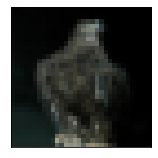

After


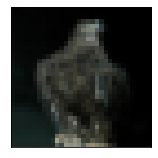

Before


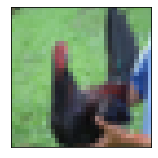

After


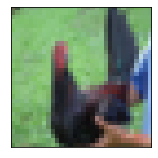

Before


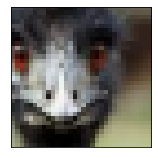

After


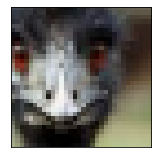

No Defense
accuracy on originals examples: 0.92
accuracy on adversarial examples: 0.01

With  spatial_smoothing defense applied

accuracy on originals examples: 0.82
accuracy on adversarial examples: 0.68

With  thermometer_encoding defense applied

accuracy on originals examples: 0.1
accuracy on adversarial examples: 0.1

With  variance_minimization defense applied

accuracy on originals examples: 0.62
accuracy on adversarial examples: 0.54

With  reverse_sigmoid defense applied

accuracy on originals examples: 0.58
accuracy on adversarial examples: 0.34

With  gaussian_noise defense applied

accuracy on originals examples: 0.91
accuracy on adversarial examples: 0.3


In [0]:
from art.attacks import ElasticNet

elastic_net = ElasticNet(classifier=classifier,batch_size=32,max_iter=1,learning_rate=0.1,binary_search_steps=9,beta=0.001)

perform_attack(elastic_net, defenses)

###DeepFool Attack


Attack effects on image
Before


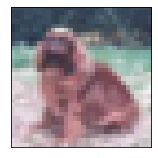

After


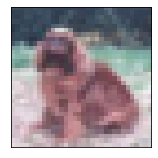

Before


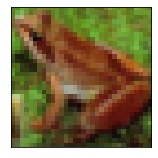

After


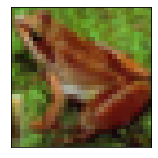

Before


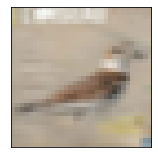

After


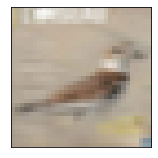

No Defense
accuracy on originals examples: 0.92
accuracy on adversarial examples: 0.26

With  spatial_smoothing defense applied

accuracy on originals examples: 0.82
accuracy on adversarial examples: 0.77

With  thermometer_encoding defense applied

accuracy on originals examples: 0.1
accuracy on adversarial examples: 0.1

With  variance_minimization defense applied

accuracy on originals examples: 0.65
accuracy on adversarial examples: 0.56

With  reverse_sigmoid defense applied

accuracy on originals examples: 0.58
accuracy on adversarial examples: 0.39

With  gaussian_noise defense applied

accuracy on originals examples: 0.92
accuracy on adversarial examples: 0.42


In [0]:
from art.attacks import DeepFool

deep_fool = DeepFool(classifier=classifier,batch_size=32,max_iter=5)

perform_attack(deep_fool, defenses)

###NewtonFool Attack


Attack effects on image
Before


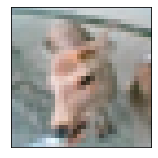

After


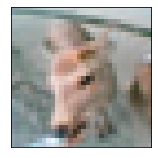

Before


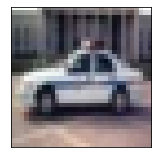

After


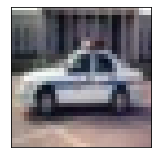

Before


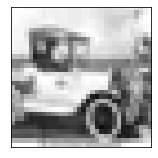

After


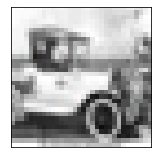

No Defense
accuracy on originals examples: 0.92
accuracy on adversarial examples: 0.59

With  spatial_smoothing defense applied

accuracy on originals examples: 0.82
accuracy on adversarial examples: 0.73

With  thermometer_encoding defense applied

accuracy on originals examples: 0.1
accuracy on adversarial examples: 0.1

With  variance_minimization defense applied

accuracy on originals examples: 0.63
accuracy on adversarial examples: 0.59

With  reverse_sigmoid defense applied

accuracy on originals examples: 0.58
accuracy on adversarial examples: 0.45

With  gaussian_noise defense applied

accuracy on originals examples: 0.91
accuracy on adversarial examples: 0.58


In [0]:
from art.attacks import NewtonFool

newton_fool = NewtonFool(classifier=classifier,batch_size=32,max_iter=1)

perform_attack(newton_fool, defenses)

###FastGradient Method


Attack effects on image
Before


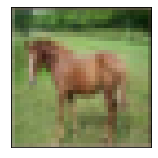

After


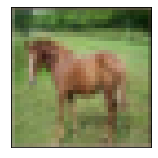

Before


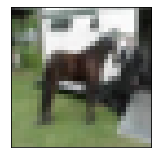

After


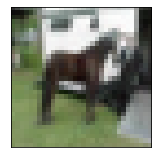

Before


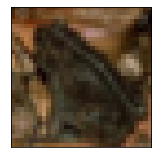

After


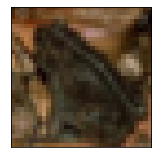

No Defense
accuracy on originals examples: 0.92
accuracy on adversarial examples: 0.73

With  spatial_smoothing defense applied

accuracy on originals examples: 0.82
accuracy on adversarial examples: 0.82

With  thermometer_encoding defense applied

accuracy on originals examples: 0.1
accuracy on adversarial examples: 0.1

With  variance_minimization defense applied

accuracy on originals examples: 0.61
accuracy on adversarial examples: 0.58

With  reverse_sigmoid defense applied

accuracy on originals examples: 0.58
accuracy on adversarial examples: 0.34

With  gaussian_noise defense applied

accuracy on originals examples: 0.92
accuracy on adversarial examples: 0.76


In [0]:
from art.attacks import FastGradientMethod

fast_gradient_method = FastGradientMethod(classifier=classifier,batch_size=32,norm=2, eps=0.3, eps_step=0.1)

perform_attack(fast_gradient_method, defenses)

###Threshold Attack

In [0]:
!pip install cma

     |████████████████████████████████| 235kB 2.8MB/s 



Attack effects on image
Before


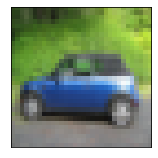

After


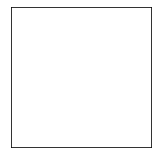

Before


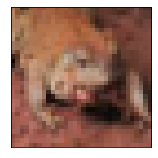

After


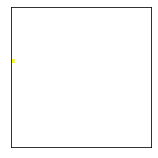

Before


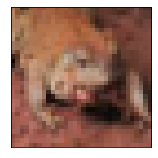

After


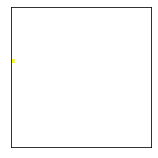

No Defense
accuracy on originals examples: 0.92
accuracy on adversarial examples: 0.1

With  spatial_smoothing defense applied

accuracy on originals examples: 0.82
accuracy on adversarial examples: 0.09

With  thermometer_encoding defense applied

accuracy on originals examples: 0.1
accuracy on adversarial examples: 0.1

With  variance_minimization defense applied

accuracy on originals examples: 0.61
accuracy on adversarial examples: 0.1

With  reverse_sigmoid defense applied

accuracy on originals examples: 0.58
accuracy on adversarial examples: 0.1

With  gaussian_noise defense applied

accuracy on originals examples: 0.91
accuracy on adversarial examples: 0.1


In [0]:
from art.attacks import ThresholdAttack

threshold_attack = ThresholdAttack(classifier=classifier,th=.01,es=0)

perform_attack(threshold_attack, defenses)

###Pixel Attack 


Attack effects on image
Before


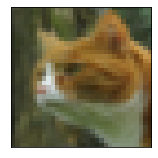

After


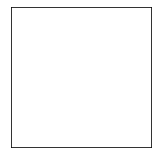

Before


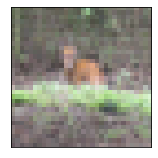

After


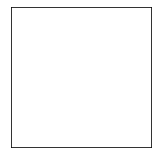

Before


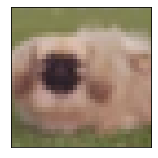

After


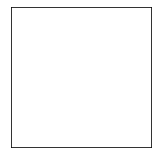

No Defense
accuracy on originals examples: 0.92
accuracy on adversarial examples: 0.1

With  spatial_smoothing defense applied

accuracy on originals examples: 0.82
accuracy on originals examples: 0.09

With  thermometer_encoding defense applied

accuracy on originals examples: 0.1
accuracy on originals examples: 0.1

With  variance_minimization defense applied

accuracy on originals examples: 0.62
accuracy on originals examples: 0.1

With  reverse_sigmoid defense applied

accuracy on originals examples: 0.58
accuracy on originals examples: 0.1

With  gaussian_noise defense applied

accuracy on originals examples: 0.92
accuracy on originals examples: 0.1


In [0]:
from art.attacks import PixelAttack

pixel_attack = PixelAttack(classifier=classifier,th=1)

perform_attack(pixel_attack, defenses)

###HopSkipJump Attack


Attack effects on image
Before


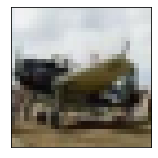

After


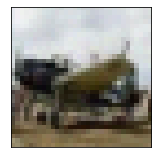

Before


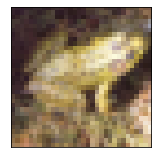

After


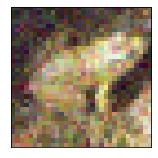

Before


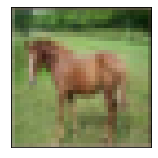

After


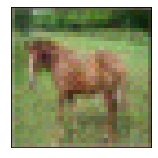

No Defense
accuracy on originals examples: 0.92
accuracy on adversarial examples: 0.07

With  spatial_smoothing defense applied

accuracy on originals examples: 0.82
accuracy on adversarial examples: 0.76

With  thermometer_encoding defense applied

accuracy on originals examples: 0.1
accuracy on adversarial examples: 0.1

With  variance_minimization defense applied

accuracy on originals examples: 0.6
accuracy on adversarial examples: 0.53

With  reverse_sigmoid defense applied

accuracy on originals examples: 0.58
accuracy on adversarial examples: 0.29

With  gaussian_noise defense applied

accuracy on originals examples: 0.92
accuracy on adversarial examples: 0.07


In [0]:
from art.attacks import HopSkipJump

hop_skip_jump = HopSkipJump(classifier=classifier,max_iter=5,max_eval=1000,norm=2)

perform_attack(hop_skip_jump, defenses)

###Adversarial Patch


Attack effects on image
Before


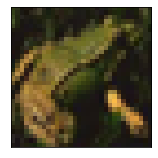

After


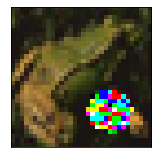

Before


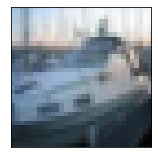

After


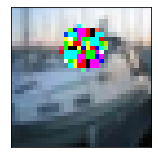

Before


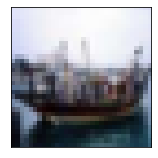

After


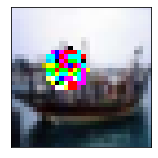

No Defense
accuracy on originals examples: 0.92
accuracy on adversarial examples: 0.1

With  spatial_smoothing defense applied

accuracy on originals examples: 0.82
accuracy on originals examples: 0.1

With  thermometer_encoding defense applied

accuracy on originals examples: 0.1
accuracy on originals examples: 0.1

With  variance_minimization defense applied

accuracy on originals examples: 0.61
accuracy on originals examples: 0.1

With  reverse_sigmoid defense applied

accuracy on originals examples: 0.58
accuracy on originals examples: 0.1

With  gaussian_noise defense applied

accuracy on originals examples: 0.92
accuracy on originals examples: 0.1


In [0]:
from art.attacks import AdversarialPatch

adversarial_patch = AdversarialPatch(classifier=classifier,)

perform_attack(adversarial_patch, defenses)

###CarliniL2Method


Attack effects on image
Before


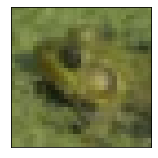

After


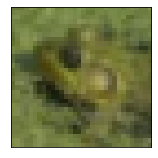

Before


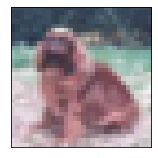

After


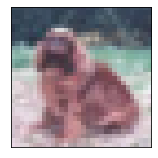

Before


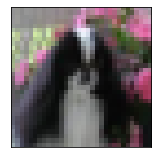

After


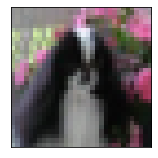

No Defense
accuracy on originals examples: 0.92
accuracy on adversarial examples: 0.0

With  spatial_smoothing defense applied

accuracy on originals examples: 0.82
accuracy on originals examples: 0.75

With  thermometer_encoding defense applied

accuracy on originals examples: 0.1
accuracy on originals examples: 0.1

With  variance_minimization defense applied

accuracy on originals examples: 0.63
accuracy on originals examples: 0.56

With  reverse_sigmoid defense applied

accuracy on originals examples: 0.58
accuracy on originals examples: 0.39

With  gaussian_noise defense applied

accuracy on originals examples: 0.92
accuracy on originals examples: 0.22


In [0]:
from art.attacks import CarliniL2Method

carlini_l2 = CarliniL2Method(classifier=classifier,batch_size=32)

perform_attack(carlini_l2, defenses)

###Carlini L_Inf Method


Attack effects on image
Before


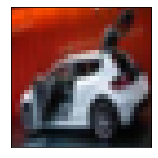

After


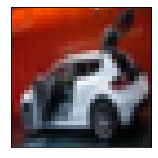

Before


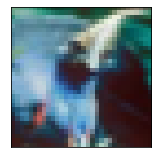

After


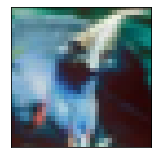

Before


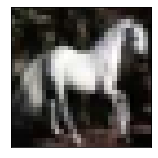

After


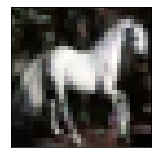

No Defense
accuracy on originals examples: 0.92
accuracy on adversarial examples: 0.0

With  spatial_smoothing defense applied

accuracy on originals examples: 0.82
accuracy on originals examples: 0.72

With  thermometer_encoding defense applied

accuracy on originals examples: 0.1
accuracy on originals examples: 0.1

With  variance_minimization defense applied

accuracy on originals examples: 0.6
accuracy on originals examples: 0.53

With  reverse_sigmoid defense applied

accuracy on originals examples: 0.58
accuracy on originals examples: 0.35

With  gaussian_noise defense applied

accuracy on originals examples: 0.93
accuracy on originals examples: 0.06


In [0]:
from art.attacks import CarliniLInfMethod

carlini_linf = CarliniLInfMethod(classifier=classifier,batch_size=50)

perform_attack(carlini_linf, defenses)

###Basic Iterative Method


Attack effects on image
Before


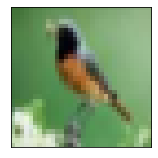

After


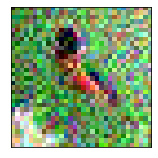

Before


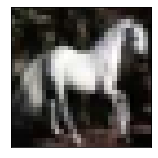

After


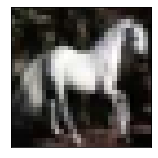

Before


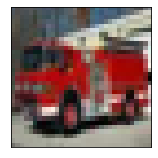

After


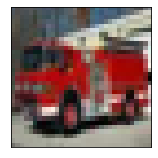

No Defense
accuracy on originals examples: 0.92
accuracy on adversarial examples: 0.32

With  spatial_smoothing defense applied

accuracy on originals examples: 0.82
accuracy on adversarial examples: 0.38

With  thermometer_encoding defense applied

accuracy on originals examples: 0.1
accuracy on adversarial examples: 0.1

With  variance_minimization defense applied

accuracy on originals examples: 0.6
accuracy on adversarial examples: 0.29

With  reverse_sigmoid defense applied

accuracy on originals examples: 0.58
accuracy on adversarial examples: 0.2

With  gaussian_noise defense applied

accuracy on originals examples: 0.92
accuracy on adversarial examples: 0.31


In [0]:
from art.attacks import BasicIterativeMethod

basic_iterative = BasicIterativeMethod(classifier=classifier,batch_size=32,eps=0.3, eps_step=0.1)

perform_attack(basic_iterative, defenses)

###Projected Gradient Descent


Attack effects on image
Before


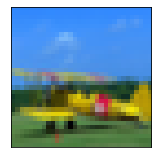

After


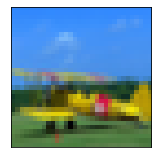

Before


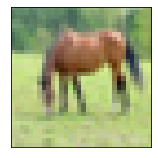

After


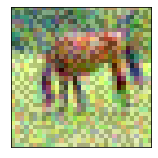

Before


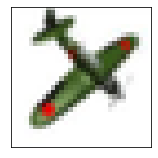

After


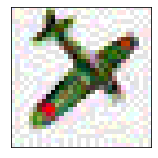

No Defense
accuracy on originals examples: 0.92
accuracy on adversarial examples: 0.32

With  spatial_smoothing defense applied

accuracy on originals examples: 0.82
accuracy on adversarial examples: 0.38

With  thermometer_encoding defense applied

accuracy on originals examples: 0.1
accuracy on adversarial examples: 0.1

With  variance_minimization defense applied

accuracy on originals examples: 0.64
accuracy on adversarial examples: 0.32

With  reverse_sigmoid defense applied

accuracy on originals examples: 0.58
accuracy on adversarial examples: 0.2

With  gaussian_noise defense applied

accuracy on originals examples: 0.92
accuracy on adversarial examples: 0.31


In [0]:
from art.attacks import ProjectedGradientDescent

projected_gradient_descent = ProjectedGradientDescent(classifier=classifier,batch_size=32,eps=0.3)

perform_attack(projected_gradient_descent, defenses)

###Jacobian Saliency Map Method


Attack effects on image
Before


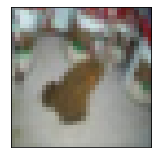

After


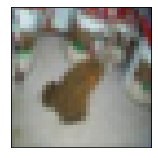

Before


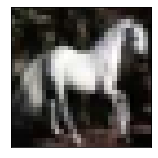

After


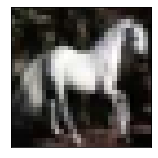

Before


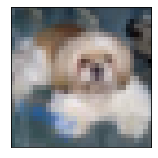

After


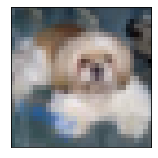

No Defense
accuracy on originals examples: 0.92
accuracy on adversarial examples: 0.93

With  spatial_smoothing defense applied

accuracy on originals examples: 0.82
accuracy on adversarial examples: 0.83

With  thermometer_encoding defense applied

accuracy on originals examples: 0.1
accuracy on adversarial examples: 0.1

With  variance_minimization defense applied

accuracy on originals examples: 0.61
accuracy on adversarial examples: 0.61

With  reverse_sigmoid defense applied

accuracy on originals examples: 0.58
accuracy on adversarial examples: 0.58

With  gaussian_noise defense applied

accuracy on originals examples: 0.92
accuracy on adversarial examples: 0.92


In [0]:
from art.attacks import SaliencyMapMethod

saliency_map = SaliencyMapMethod(classifier=classifier,theta=0.1, gamma=1.0)

perform_attack(saliency_map, defenses)

###Spatial Transformations Attack


Attack effects on image
Before


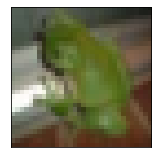

After


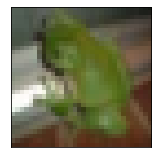

Before


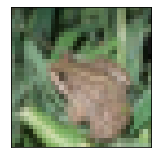

After


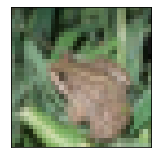

Before


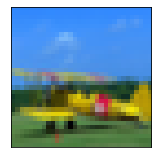

After


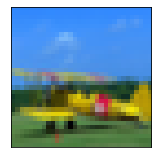

No Defense
accuracy on originals examples: 0.92
accuracy on adversarial examples: 0.92

With  spatial_smoothing defense applied

accuracy on originals examples: 0.82
accuracy on adversarial examples: 0.82

With  thermometer_encoding defense applied

accuracy on originals examples: 0.1
accuracy on adversarial examples: 0.1

With  variance_minimization defense applied

accuracy on originals examples: 0.6
accuracy on adversarial examples: 0.59

With  reverse_sigmoid defense applied

accuracy on originals examples: 0.58
accuracy on adversarial examples: 0.58

With  gaussian_noise defense applied

accuracy on originals examples: 0.93
accuracy on adversarial examples: 0.93


In [0]:
from art.attacks import SpatialTransformation

spatial_transformation = SpatialTransformation(classifier=classifier,max_translation=0.0, num_translations=1, max_rotation=0.0, num_rotations=1)

perform_attack(spatial_transformation, defenses)

###Universal Perturbation Attack

art.attacks.evasion.deepfool.DeepFool

Attack effects on image
Before


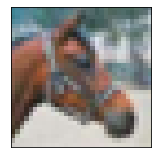

After


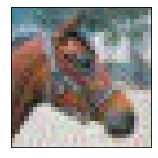

Before


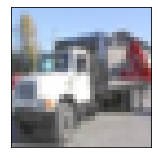

After


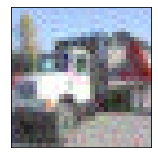

Before


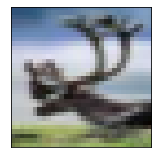

After


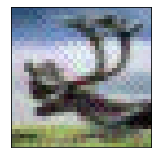

No Defense
accuracy on originals examples: 0.92
accuracy on adversarial examples: 0.21

With  spatial_smoothing defense applied

accuracy on originals examples: 0.82
accuracy on adversarial examples: 0.71

With  thermometer_encoding defense applied

accuracy on originals examples: 0.1
accuracy on adversarial examples: 0.1

With  variance_minimization defense applied

accuracy on originals examples: 0.61
accuracy on adversarial examples: 0.59

With  reverse_sigmoid defense applied

accuracy on originals examples: 0.58
accuracy on adversarial examples: 0.25

With  gaussian_noise defense applied

accuracy on originals examples: 0.91
accuracy on adversarial examples: 0.24


In [0]:
from art.attacks import UniversalPerturbation

universal_perturbation = UniversalPerturbation(classifier=classifier,attacker='deepfool', delta=0.2, max_iter=10, eps=10.0, norm=2)

perform_attack(universal_perturbation, defenses)

###Zeroth Order Optimization Attack


Attack effects on image
Before


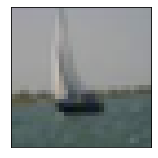

After


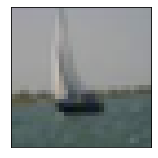

Before


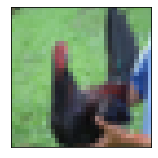

After


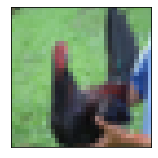

Before


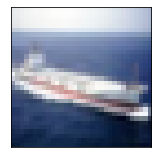

After


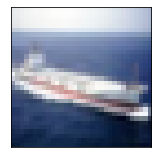

No Defense
accuracy on originals examples: 0.92
accuracy on adversarial examples: 0.91

With  spatial_smoothing defense applied

accuracy on originals examples: 0.82
accuracy on adversarial examples: 0.82

With  thermometer_encoding defense applied

accuracy on originals examples: 0.1
accuracy on adversarial examples: 0.1

With  variance_minimization defense applied

accuracy on originals examples: 0.62
accuracy on adversarial examples: 0.62

With  reverse_sigmoid defense applied

accuracy on originals examples: 0.58
accuracy on adversarial examples: 0.58

With  gaussian_noise defense applied

accuracy on originals examples: 0.93
accuracy on adversarial examples: 0.92


In [0]:
from art.attacks import ZooAttack

zoo_attack = ZooAttack(classifier=classifier, max_iter = 1, binary_search_steps=5)

perform_attack(zoo_attack, defenses)

###Virtual Adversarial Method*

In [0]:
va_classifier = art.classifiers.KerasClassifier(model = victim_model, clip_values=[0,1])

In [0]:
from art.attacks import VirtualAdversarialMethod

virtual_adversarial = VirtualAdversarialMethod(classifier=va_classifier, batch_size=32)

perform_attack(virtual_adversarial, defenses)

TypeError: ignored